##### Random Forrest has been used to predict stock price difference from previous day stock price and technical indicators

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data_model.csv', header=0, parse_dates=[0])
df_cleaned = df.dropna()
df_cleaned.head(5)

,Date,Diff,Close-Open,High-Low,RSI,Close-EMA,MACD-Signal,ADX,CCI,NormATR,Close-BBup,Close-BBmid,Close-BBlow,Diff_t+1
33,2021-06-14,12.50,20.45,216.55,71.283947,220.522137,-11.062793,30.701480,73.768483,1.013346,-58.001894,66.97,191.941894,57.40
34,2021-06-15,57.40,2.30,59.20,72.757895,240.865852,-10.284952,30.241329,131.489400,0.977958,-60.536263,98.54,257.616263,-101.70
35,2021-06-16,-101.70,-79.95,138.25,66.267762,120.610405,-18.454491,29.063859,86.183101,0.976589,-118.251497,-29.60,59.051497,-76.15
36,2021-06-17,-76.15,43.10,152.60,61.821008,38.532351,-30.131212,27.133862,-3.409170,0.980699,-213.266636,-96.48,20.306636,-8.05
37,2021-06-18,-8.05,-73.15,310.60,61.352321,26.418037,-38.979394,25.979041,-73.215266,1.052577,-223.182481,-81.33,60.522481,63.15


In [3]:
# random forrest classifer

df_cleaned_rndfclass = df_cleaned.copy()
df_cleaned_rndfclass['Y'] = np.where(df_cleaned_rndfclass['Diff_t+1']>=0,1,0)
df_cleaned_rndfclass = df_cleaned_rndfclass.drop(['Diff_t+1','Diff'], axis=1)

x = df_cleaned_rndfclass.drop(['Date','Y'], axis=1)
y = df_cleaned_rndfclass['Y']
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
 
X_train_pca = sc.fit_transform(X_train)
X_test_pca = sc.transform(X_test)

pca = PCA(n_components = 3)
 
X_train_pca_results = pca.fit_transform(X_train_pca)
X_test_pca_results = pca.transform(X_test_pca)
 
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.51927051, 0.17029996, 0.10107766])

In [5]:
import plotly.express as px

data_pca_plt = np.hstack((X_test_pca_results,y_test.to_numpy().reshape(-1,1)))
column_values = ['comp1', 'comp2', 'comp3','direction']
df_pca_plot = pd.DataFrame(data = data_pca_plt, columns = column_values)

df = px.data.iris()
fig = px.scatter_3d(df_pca_plot, x='comp1', y='comp2', z='comp3', color='direction')
# fig = px.scatter(df_pca_plot, x='comp1', y='comp2', color='direction')
fig.show()

In [6]:
%%time

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10,25,30,50,100,200]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 10,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
rf_best

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
0.5833333333333333
CPU times: total: 33.2 s
Wall time: 5min 7s


RandomForestClassifier(max_depth=5, min_samples_leaf=10, n_estimators=25,
                       n_jobs=-1, random_state=42)

In [7]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 25}

In [8]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
8,Close-BBup,0.249912
7,NormATR,0.150961
3,Close-EMA,0.114095
0,Close-Open,0.088683
6,CCI,0.077935
10,Close-BBlow,0.069826
5,ADX,0.067922
2,RSI,0.054705
4,MACD-Signal,0.047963
1,High-Low,0.043246


In [9]:
# selecting best random forrest hyperparameters
classifier_rf = RandomForestClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=2, n_estimators=25,
                       n_jobs=-1, random_state=42,oob_score=True)
classifier_rf.fit(X_train, y_train)
classifier_rf.oob_score_

0.5570469798657718

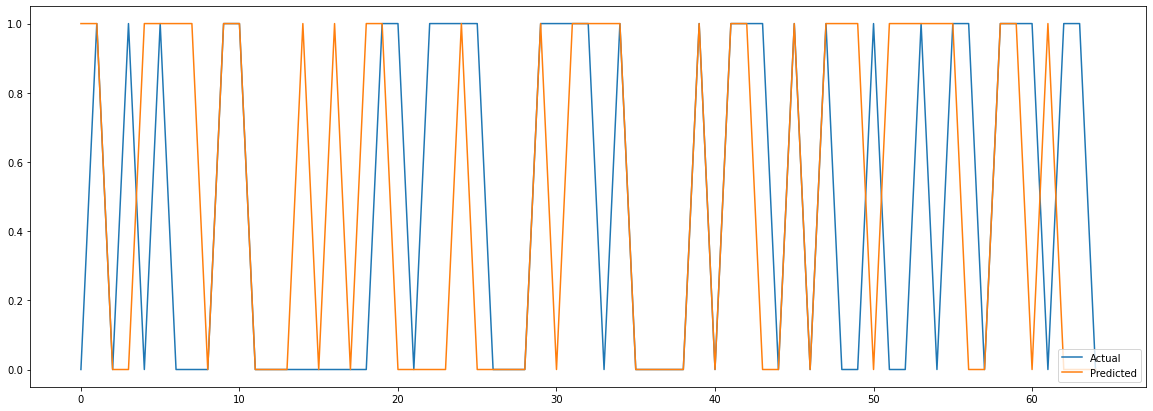

Directional error percentage: 60.0


In [10]:
# Actual vs Fitted
predictions = classifier_rf.predict(X_test)
y_test = y_test.to_numpy()
plt.figure(figsize=(20,7))
plt.plot(y_test)
plt.plot(predictions)
plt.legend(["Actual", "Predicted"], loc ="lower right")
plt.show()

z=0
for i in range(y_test.shape[0]):
    if y_test[i]==predictions[i]:
        z=z+1

print("Directional error percentage:", z/y_test.shape[0]*100)